Missing compiler_cxx fix for MSVCCompiler


WARNING    Cannot use weave, a test compilation failed: error: Microsoft Visual C++ 9.0 is required. Get it from http://aka.ms/vcpython27 (CompileError) [brian2.codegen.runtime.weave_rt.weave_rt.failed_compile_test]
WARNING    d:\anaconda3\envs\bmnn\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\holmosaint\.cython\brian_extensions\_cython_magic_7415aef673dee03da8a8c2ac4090bf59.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 9.0 is required. Get it from http://aka.ms/vcpython27 (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to

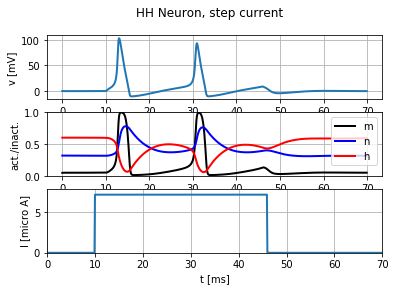

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.hodgkin_huxley import HH
from neurodynex.tools import input_factory

HH.getting_started()

What is the lowest step current amplitude I_min for generating at least one spike?

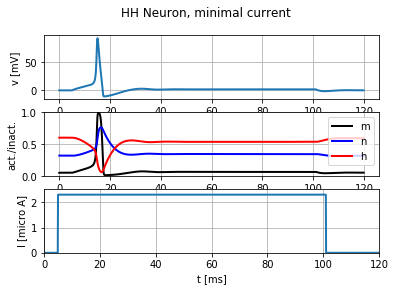

In [2]:
I_min = 2.3
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

It seems that the minimal step current to generate a single spike is about $2.3\mu A$

What is the lowest step current amplitude to generate repetitive firing?
Discuss the difference between the two regimes.

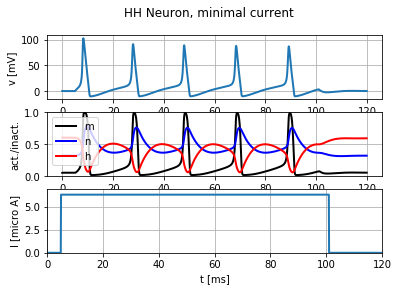

In [3]:
I_min = 6.3
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

It seems that the lowest step current amplitude to genrate repetitive firing is $6.3\mu A$

Inject a slow ramp current into a HH neuron. The current has amplitude $0A$ at t in `[0, 5]` ms and linearly increases to an amplitude of $12.0\mu Amp$ at `t=ramp_t_end`. At `t>ramp_t_end`, the current is set to $0A$. Using the following code, reduce `slow_ramp_t_end` to the maximal duration of the ramp current, such that the neuron does not spike. Make sure you simulate system for at least $20ms$ after the current stops.

voltage_slow=0.00878306041869


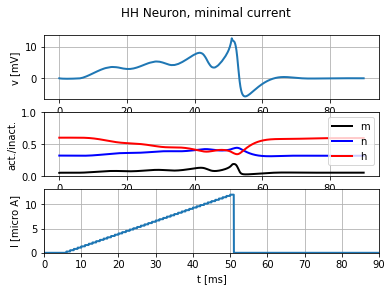

In [4]:
b2.defaultclock.dt = 0.02*b2.ms
slow_ramp_t_end = 50  # no spike. make it shorter
slow_ramp_current = input_factory.get_ramp_current(5, 
                                                   slow_ramp_t_end, 
                                                   b2.ms, 
                                                   0.*b2.uA, 
                                                   12.0*b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, 90 * b2.ms)
idx_t_end = int(round(slow_ramp_t_end*b2.ms / b2.defaultclock.dt))
voltage_slow = state_monitor.vm[0,idx_t_end]
print("voltage_slow={}".format(voltage_slow))
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

The maximal duration to generate a spike is at round $49ms$

voltage_fast=0.00620703566781


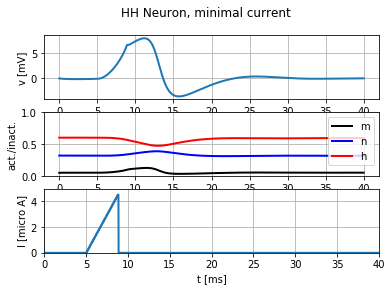

In [5]:
b2.defaultclock.dt = 0.02*b2.ms
fast_ramp_t_end = 88  # no spike. make it longer
fast_ramp_current = input_factory.get_ramp_current(50, 
                                                   fast_ramp_t_end, 
                                                   0.1*b2.ms, 
                                                   0.*b2.uA, 
                                                   4.5*b2.uA)
state_monitor = HH.simulate_HH_neuron(fast_ramp_current, 40 * b2.ms)
idx_t_end = int(round(fast_ramp_t_end*0.1*b2.ms / b2.defaultclock.dt))
voltage_fast = state_monitor.vm[0,idx_t_end]
print("voltage_fast={}".format(voltage_fast))
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

The maximal duration to generate a spike is at round $99ms$

The slope of the current increase is slower of the first experiment than the second one. As the time constants of $h$ and $n$ are much larger than that of $m$, the slower increase of the membrane potential allows for the relative decrease of $h$ to be larger, so that there is a compenstation effect between the increase of $m$ and the decrease of $h$, and also the inactivation of potasium channel controlled by $n$. In the second experiment, the increase of current is fast, due to the small time constant of $m$, it can quickly improve relative to the slow decrease of $h$, thus it will have a smaller threshold to create a spike.

In [6]:
def simulate_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * 1.4 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

In the source code of your function, change the density of sodium channels. Increase it by a factor of 1.4. Stimulate this modified neuron with a step current.

- What is the minimal current leading to repetitive spiking? Explain.
- Run a simulation with no input current to determine the resting potential of the neuron. Link your observation to the Goldman–Hodgkin–Katz voltage equation.
- If you increase the sodium conductance further, you can observe repetitive firing even in the absence of input, why?

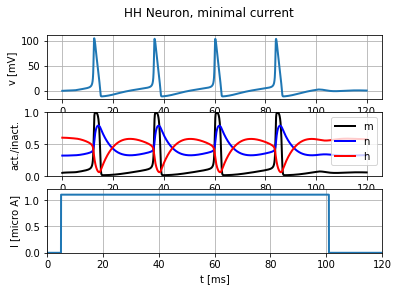

In [7]:
I_min = 1.1
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, minimal current")

It only needs $1.1\mu A$ to generate repetitive spikes, because the influx of $\text{Na}^+$ via $\text{Na}^+$ channel is the main reason that causes an AP. So the increase of the conductance of $\text{Na}^+$ will definitely make the neuron more likely to generate APs.

WARNING    d:\anaconda3\envs\bmnn\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
 [py.warnings]


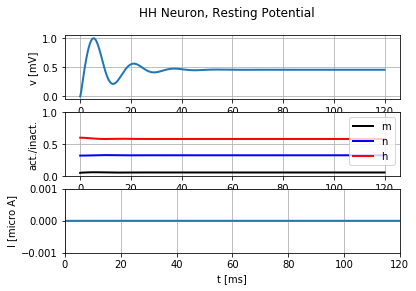

In [8]:
I_min = 0
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, Resting Potential")

According to the equation below:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/acc6125fa94136c1129f1916983a111125d2cec0">

The increase of conductancy of $\text{Na}^+$ channels will result in the increase of selectivity of $\text{Na}^+$ ions. And the $[\text{Na}^+]_{\text{out}}$ is larger than $[\text{Na}^+]_{\text{in}}$, so the resting potential will increase, as shown in the above picture that the resting potential is around $+0.5mV$.

If I increase the conductancy of $[\text{Na}^+]$ channels, it will firing repetitively without stimuli, because the resting potential is high enough to cause the changes of $m, n, h$, which determine the generation of an AP.